In [1]:
import pennylane as qml
import numpy as np
from itertools import permutations,combinations
import matplotlib.pyplot as plt
%matplotlib inline

# Autoencoder
### Circuits to train the optimal parameters for autoencoder

In [16]:
def ctr_rot(paras,ctr=None,targ=None):
    """
    Decomposition of a Control-rotation gate to 3 single-qubit rotation gates and 2 CNOTs.

    paras:
        list: List of 3 parameters for RZ, RY and RZ rotation respectively.
    ctr:
        int: Wire index for control qubit.
    targ:
        int: Wire index for target qubit.

    """
    if ctr is None or targ is None:
            raise ValueError(f"Need to assign wires for control and target qubits.")
    if len(paras) != 3:
            raise ValueError(f"3 Parameters needed; Got {len(paras)}.")
    qml.RZ(paras[0], wires=targ)
    qml.CNOT(wires=[ctr,targ])
    qml.RY(paras[1], wires=targ)
    qml.CNOT(wires=[ctr,targ])
    qml.RZ(paras[2], wires=targ)

def general_two_qubit(paras,q0=None,q1=None):
    """
    Decomposition of a general two-qubit gate to 15 single-qubit rotation gates and 3 CNOTs.
    Ref: arXiv:quant-ph/0308006

    paras:
        list: List of 15 parameters.
    ctr:
        int: Wire index for qubit 0.
    targ:
        int: Wire index for qubit 1.      
    """
    if q0 is None or q1 is None:
            raise ValueError(f"Need to assign wires for q0 and q1.")
    if len(paras) != 15:
            raise ValueError(f"15 Parameters needed; Got {len(paras)}.")
    qml.RZ(paras[0], wires=q0)
    qml.RY(paras[1], wires=q0)
    qml.RZ(paras[2], wires=q0)

    qml.RZ(paras[3], wires=q1)
    qml.RY(paras[4], wires=q1)
    qml.RZ(paras[5], wires=q1)

    qml.CNOT(wires=[q1,q0])
    qml.RZ(paras[6], wires=q0)
    qml.RY(paras[7], wires=q1)
    qml.CNOT(wires=[q0,q1])
    qml.RY(paras[8], wires=q1)
    qml.CNOT(wires=[q1,q0])

    qml.RZ(paras[9], wires=q0)
    qml.RY(paras[10], wires=q0)
    qml.RZ(paras[11], wires=q0)

    qml.RZ(paras[12], wires=q1)
    qml.RY(paras[13], wires=q1)
    qml.RZ(paras[14], wires=q1)

def main_train(n_comp,input_data=None,model="B",optimizer="GradientDescent",opt_steps=500):
    """
    Args:
        n_comp (int): Number of compressed qubit, n_comp < n_inp
        input_data (list[list[float],...]): The data to be encoded into the amplitude of the quantum state, followed with normalization.
        model (str): The autoencoder model of circuit: 
            Two choices "A" and "B" corresponding to the two circuits shown in Fig. 3 (arXiv:1612.02806v2).
        optimizer (str): Choice of optimizer:
            "GradientDescent", "AdagradOptimizer", or more to be added.
        opt_steps (int): Optimization steps.
        
    Returns:
        params (list[float]): Optimal parameters after optimziation.
        cost_data (list[float]): Cost function values.
    """
    
    n_inp = int(np.log2(len(input_data[0])))  # Num of input qubits
    anc = 1     # Ancilla qubit
    totqubit = n_inp+n_inp-n_comp+anc
    allwires = [i for i in range(totqubit)]
    dev = qml.device('default.qubit', wires=totqubit)  
        
    @qml.qnode(dev)
    def circuit(params,inp=None):
        if len(inp) != 2**n_inp:
                    raise ValueError(f"Input state-vector length wrong! Got length {len(inp)}")
        
        # Qubit encoding. Here |0>^n_trash is default reference state.
        qml.AmplitudeEmbedding(features=inp, wires=allwires[:n_inp],normalize=True)
        
        if model=="A":
            if len(params) != 15*n_inp*(n_inp-1)/2:
                        raise ValueError(f"The number of parameters must be {15*n_inp*(n_inp-1)/2}; Got length {len(params)}.")
            
            # Prepare U
            paracnt = 0
            comb = list(combinations(allwires[:n_inp], 2))
            for i in comb:
                general_two_qubit(paras=params[paracnt:paracnt+15],q0=i[0],q1=i[1])
                paracnt += 15
                
        elif model=="B":
            if len(params) != 3*n_inp*(n_inp-1)+6*n_inp:
                        raise ValueError(f"The number of parameters must be {3*n_inp*(n_inp-1)+6*n_inp}; Got length {len(params)}.")
                    
            # Prepare U
            paracnt = 0
            for i in range(n_inp):
                qml.RZ(params[paracnt], wires=i)
                qml.RY(params[paracnt+1], wires=i)
                qml.RZ(params[paracnt+2], wires=i)
                paracnt += 3

            perm = list(permutations(allwires[:n_inp], 2))
            for i in perm:
                ctr_rot(paras=params[paracnt:paracnt+3],ctr=i[0],targ=i[1])
                paracnt += 3

            for i in range(n_inp):
                qml.RZ(params[paracnt], wires=i)
                qml.RY(params[paracnt+1], wires=i)
                qml.RZ(params[paracnt+2], wires=i)
                paracnt += 3
        else:
            raise ValueError(f"Invalid model chosen!")

        # SWAP Test
        qml.Hadamard(wires=totqubit-1)
        for i in allwires[n_comp:n_inp]:
            qml.CSWAP(wires=[totqubit-1,i,i+n_inp-n_comp])
        qml.Hadamard(wires=totqubit-1)

        return qml.expval(qml.PauliZ(totqubit-1))
    
    def cost(params):
        """
        Cost function. Defined by Eq. 7 (C2) in the paper arXiv:1612.02806v2.
        """
        C2 = 0
        for inp in input_data:
            res = circuit(params,inp) 
            C2 = C2 + res
        return 1-C2/len(input_data)
    
    # Optimization
    if model=="A":
        init_params = np.random.random(int(15*n_inp*(n_inp-1)/2))
    elif model=="B":   
        init_params = np.random.random(int(3*n_inp*(n_inp-1)+6*n_inp) )
    
    if optimizer=="GradientDescent":
        opt = qml.GradientDescentOptimizer(stepsize=0.1)
    elif optimizer=="AdagradOptimizer":
        opt = qml.AdagradOptimizer(stepsize=0.1)
    else:
         raise ValueError(f"Invalid optimizer chosen!")
    
    params = init_params
    cost_data = []
    print(f"Cost at step 0:     {cost(params)}")
    for i in range(opt_steps):
        params = opt.step(cost, params)
        cost_data.append(cost(params))
        if (i+1)%(5) == 0:
            print(f"Cost after step {i+1}: {cost_data[-1]}")
        if cost_data[-1]<10e-4: # minimum cost threshold
            print(f"Cost after step {i+1}: {cost_data[-1]}")
            print("-------------------")
            print("Cost below threshold (10e-4). Optimization stop here.")
            break
    #fig, ax = qml.draw_mpl(circuit, decimals=2)(params,input_data[0])
    #display(plt.show())
    return params.tolist(),cost_data

### Define the train set and trian the model
#### Here we use 2x2 binary image data as train set data

In [3]:
m = [[1,0,0,1],[0,1,1,0],[0,1,1,0],[0,1,1,0],[0,1,1,0],[0,1,1,0],[0,1,1,0],[1,0,0,1]]
res,c = main_train(n_comp=1,input_data=m,model="A",optimizer="GradientDescent") 

Cost at step 0:     0.36360420685474804


d:\ProgramData\Anaconda3\lib\site-packages\pennylane\_grad.py:100: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  UserWarning,


Cost after step 5: 0.28976065461096145
Cost after step 10: 0.215987151712295
Cost after step 15: 0.15114301041469214
Cost after step 20: 0.10126208591651453
Cost after step 25: 0.06678120582825708
Cost after step 30: 0.044524068551183626
Cost after step 35: 0.030622876423503476
Cost after step 40: 0.021985597416422475
Cost after step 45: 0.0165357424231799
Cost after step 50: 0.012990739755016412
Cost after step 55: 0.01058919027321148
Cost after step 60: 0.008886147195560357
Cost after step 65: 0.0076219130047483485
Cost after step 70: 0.0066435430806092155
Cost after step 75: 0.005859375643259224
Cost after step 80: 0.005213074044195132
Cost after step 85: 0.004668879676383408
Cost after step 90: 0.004203222025823905
Cost after step 95: 0.0037999153947800846
Cost after step 100: 0.003447379076980117
Cost after step 105: 0.0031370033104886064
Cost after step 110: 0.0028621686674171753
Cost after step 115: 0.002617642110824381
Cost after step 120: 0.0023991933874889515
Cost after step 

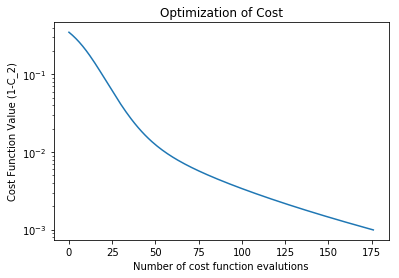

None

In [4]:
x =np.linspace(1, len(c), len(c))
plt.plot(x, c)
plt.title("Optimization of Cost")
plt.xlabel("Number of cost function evalutions")
plt.ylabel("Cost Function Value (1-C_2)")
plt.yscale("log")
display(plt.show())

# Autoencoder-Decoder
### With the optimal parameters, prepare the testing circuit of encoder-decoder.

In [5]:
def general_two_qubit_dagger(paras,q0=None,q1=None):
    """
    Decomposition of a general two-qubit gate dagger to 15 single-qubit rotation gates and 3 CNOTs.
    Ref: arXiv:quant-ph/0308006

    paras:
        list: List of 15 parameters.
    ctr:
        int: Wire index for qubit 0.
    targ:
        int: Wire index for qubit 1.      
    """
    if q0 is None or q1 is None:
            raise ValueError(f"Need to assign wires for q0 and q1.")
    if len(paras) != 15:
            raise ValueError(f"15 Parameters needed; Got {len(paras)}.")
    qml.RZ(paras[0], wires=q1)
    qml.RY(paras[1], wires=q1)
    qml.RZ(paras[2], wires=q1)

    qml.RZ(paras[3], wires=q0)
    qml.RY(paras[4], wires=q0)
    qml.RZ(paras[5], wires=q0)

    qml.CNOT(wires=[q1,q0])
    qml.RY(paras[6], wires=q1)
    qml.CNOT(wires=[q0,q1])
    qml.RY(paras[7], wires=q1)
    qml.RZ(paras[8], wires=q0)
    qml.CNOT(wires=[q1,q0])

    qml.RZ(paras[9], wires=q1)
    qml.RY(paras[10], wires=q1)
    qml.RZ(paras[11], wires=q1)

    qml.RZ(paras[12], wires=q0)
    qml.RY(paras[13], wires=q0)
    qml.RZ(paras[14], wires=q0)
        
def main_test(n_comp,params,input_data=None,model="B"):
    """
    Args:
        n_comp (int): Number of compressed qubit, n_comp < n_inp.
        params (list[float]): Optimal parameters after optimziation.
        input_data (list[list[float],...]): The test set data, followed with normalization.
        model (str): The autoencoder model of circuit: 
            Two choices "A" and "B" corresponding to the two circuits shown in Fig. 3 (arXiv:1612.02806v2).
        
    Returns:
        output (list[float]): The output after decoding the compressed infomation, with normalization.
    """
    
    n_inp = int(np.log2(len(input_data)))  # Num of input qubits
    totqubit = n_inp+n_inp-n_comp
    allwires = [i for i in range(totqubit)]
    dev2 = qml.device('default.qubit', wires=totqubit)  

    @qml.qnode(dev2)
    def test_circuit(params,inp=None):
        if len(inp) != 2**n_inp:
                    raise ValueError(f"Input state-vector length wrong! Got length {len(inp)}")
        
        # Apply Encoder
        ## Initializing the qubit with input data
        qml.AmplitudeEmbedding(features=inp, wires=allwires[:n_inp],normalize=True)
    
        if model=="A":
            if len(params) != 15*n_inp*(n_inp-1)/2:
                        raise ValueError(f"The number of parameters must be {15*n_inp*(n_inp-1)/2}; Got length {len(params)}.")
            
            ### Prepare U
            paracnt = 0
            comb = list(combinations(allwires[:n_inp], 2))
            for i in comb:
                general_two_qubit(paras=params[paracnt:paracnt+15],q0=i[0],q1=i[1])
                paracnt += 15
                
        elif model=="B":
            if len(params) != 3*n_inp*(n_inp-1)+6*n_inp:
                        raise ValueError(f"The number of parameters must be {3*n_inp*(n_inp-1)+6*n_inp}; Got length {len(params)}.")
                    
            ### Prepare U
            paracnt = 0
            for i in range(n_inp):
                qml.RZ(params[paracnt], wires=i)
                qml.RY(params[paracnt+1], wires=i)
                qml.RZ(params[paracnt+2], wires=i)
                paracnt += 3
            perm = list(permutations(allwires[:n_inp], 2))
            for i in perm:
                ctr_rot(paras=params[paracnt:paracnt+3],ctr=i[0],targ=i[1])
                paracnt += 3
            for i in range(n_inp):
                qml.RZ(params[paracnt], wires=i)
                qml.RY(params[paracnt+1], wires=i)
                qml.RZ(params[paracnt+2], wires=i)
                paracnt += 3
        else:
            raise ValueError(f"Invalid model chosen!")
        
        
        # Apply Decoder
        rev_params = (-1*params).tolist()
        rev_params.reverse()
        all_wires2 = allwires[:n_comp]+allwires[n_inp:]
        
        if model=="A":
            ### Prepare U_dagger
            paracnt = 0
            comb = list(combinations(all_wires2, 2))
            comb.reverse()
            for i in comb:
                general_two_qubit_dagger(paras=rev_params[paracnt:paracnt+15],q0=i[0],q1=i[1])
                paracnt += 15 
                
        elif model=="B":
            inv_wires = all_wires2.copy()
            inv_wires.reverse()
            
            ### Prepare U_dagger
            paracnt = 0
            for i in inv_wires:
                qml.RZ(rev_params[paracnt], wires=i)
                qml.RY(rev_params[paracnt+1], wires=i)
                qml.RZ(rev_params[paracnt+2], wires=i)
                paracnt += 3
            perm = list(permutations(all_wires2, 2))
            perm.reverse()     
            for i in perm:
                ctr_rot(paras=rev_params[paracnt:paracnt+3],ctr=i[0],targ=i[1])
                paracnt += 3
            for i in inv_wires:
                qml.RZ(rev_params[paracnt], wires=i)
                qml.RY(rev_params[paracnt+1], wires=i)
                qml.RZ(rev_params[paracnt+2], wires=i)
                paracnt += 3
        else:
            raise ValueError(f"Invalid model chosen!") 
        return qml.probs(wires=all_wires2)

    output = test_circuit(params,inp=input_data)
    #fig, ax = qml.draw_mpl(test_circuit, decimals=2)(params,input_data)
    #display(plt.show())
    return np.sqrt(output)

# Feed test set data and compare output with input

In [7]:
inp = [0,1,1,0]
outp = main_test(n_comp=1,params=res,input_data=inp,model="A")
print("After Normalization:")
norm_input = [float(i)/np.linalg.norm(inp) for i in inp]
print(f"Input data:  {np.round(norm_input,8)}")  # Print normalized input data
print(f"Output data: {outp}") # Print normalized output

After Normalization:
Input data:  [0.         0.70710678 0.70710678 0.        ]
Output data: [0.00517783 0.70131296 0.71281474 0.00533522]


In [8]:
inp = [5,2,2,5]
outp = main_test(n_comp=1,params=res,input_data=inp,model="A")
print("After Normalization:")
norm_input = [float(i)/np.linalg.norm(inp) for i in inp]
print(f"Input data:  {np.round(norm_input,8)}")  # Print normalized input data
print(f"Output data: {outp}") # Print normalized output

After Normalization:
Input data:  [0.65653216 0.26261287 0.26261287 0.65653216]
Output data: [0.6296955  0.25967646 0.26909548 0.68091067]


In [9]:
inp = [8,2,3,9]
outp = main_test(n_comp=1,params=res,input_data=inp,model="A")
print("After Normalization:")
norm_input = [float(i)/np.linalg.norm(inp) for i in inp]
print(f"Input data:  {np.round(norm_input,8)}")  # Print normalized input data
print(f"Output data: {outp}") # Print normalized output

After Normalization:
Input data:  [0.63644583 0.15911146 0.23866719 0.71600156]
Output data: [0.6495943  0.20049888 0.20949982 0.70280671]


# Demonstration with 8x8 handwriting image.

Import a dataset of 8x8 handwriting images.

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\datasets\base.py:550: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target = data[:, -1].astype(np.int)


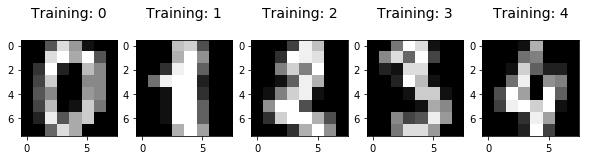

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()

plt.figure(figsize=(10,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 14);

To simiplify the problem, here I only use digit 0 and digit 1. 

And to save training time, I prepare 10 images for training set and 3 images for test set.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=0)

def get_01(X,y):
    idx = np.logical_or(np.equal(y,0) ,  np.equal(y,1))
    X = X[idx,:]
    y = y[idx]
    return X,y

X_test,y_test = get_01(X_test,y_test)
X_train,y_train = get_01(X_train,y_train)
X_train,y_train = X_train[1:11],y_train[1:11]
X_test,y_test = X_test[2:5],y_test[2:5]

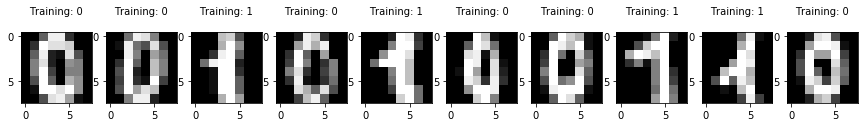

In [13]:
plt.figure(figsize=(15,4))
for index, (image, label) in enumerate(zip(X_train, y_train)):
    plt.subplot(1, 10, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 10);

##### Training with autoencoder model A. Compress 64 bit data (6 qubit) to 4 qubit quantum data.

In [17]:
res,c = main_train(n_comp=4,input_data=X_train,model="A",optimizer="GradientDescent") 

Cost at step 0:     0.6581118213423771


d:\ProgramData\Anaconda3\lib\site-packages\pennylane\_grad.py:100: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  UserWarning,


Cost after step 5: 0.3622248851502159
Cost after step 10: 0.2766852477002345
Cost after step 15: 0.24551175674874026
Cost after step 20: 0.22723732577472622
Cost after step 25: 0.21453892755340287
Cost after step 30: 0.2051144320031254
Cost after step 35: 0.19779988762908718
Cost after step 40: 0.191902304588916
Cost after step 45: 0.18698886875166054
Cost after step 50: 0.1827836729677852
Cost after step 55: 0.17910733566557702
Cost after step 60: 0.17583985132815805
Cost after step 65: 0.17289771194311787
Cost after step 70: 0.17022009293534945
Cost after step 75: 0.16776073523510404
Cost after step 80: 0.16548327944694896
Cost after step 85: 0.16335858177095974
Cost after step 90: 0.16136309502185409
Cost after step 95: 0.15947778611984642
Cost after step 100: 0.15768731610901
Cost after step 105: 0.15597935996854806
Cost after step 110: 0.15434402164316996
Cost after step 115: 0.1527733324716145
Cost after step 120: 0.15126082998100399
Cost after step 125: 0.14980121293572457
Cost 

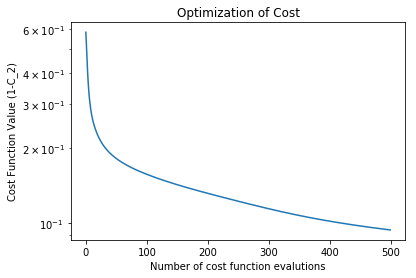

None

In [18]:
x =np.linspace(1, len(c), len(c))
plt.plot(x, c)
plt.title("Optimization of Cost")
plt.xlabel("Number of cost function evalutions")
plt.ylabel("Cost Function Value (1-C_2)")
plt.yscale("log")
display(plt.show())

Input data, before encode:


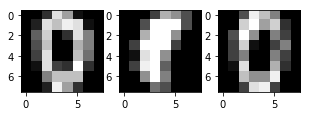

Output data, after decode:


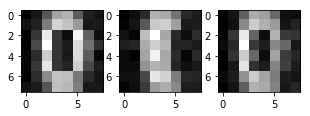

In [19]:
X_test_decode = []
for j in range(len(X_test)):
    X_test_decode.append(list(main_test(n_comp=4,params=res,input_data=X_test[j],model="A")))

plt.figure(figsize=(5,4))
print("Input data, before encode:")
for index, (image, label) in enumerate(zip(X_test, y_test)):
    plt.subplot(1, 3, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
plt.show()

plt.figure(figsize=(5,4))
print("Output data, after decode:")
for index, (image, label) in enumerate(zip(X_test_decode, y_test)):
    plt.subplot(1, 3, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
plt.show()

##### Training with autoencoder model B. Compress 64 bit data (6 qubit) to 4 qubit quantum info.

In [20]:
res2,c2 = main_train(n_comp=4,input_data=X_train,model="B",optimizer="GradientDescent") 

Cost at step 0:     0.8498726018933858
Cost after step 5: 0.8222489409332625
Cost after step 10: 0.7689169781812166
Cost after step 15: 0.6601340282566612
Cost after step 20: 0.5253116734116154
Cost after step 25: 0.4522439041869494
Cost after step 30: 0.41471363147763396
Cost after step 35: 0.38568334352784706
Cost after step 40: 0.3607640646223439
Cost after step 45: 0.3393154757445973
Cost after step 50: 0.32089909805549843
Cost after step 55: 0.3050471417541518
Cost after step 60: 0.2913160237495228
Cost after step 65: 0.2793229162851524
Cost after step 70: 0.26875561044756535
Cost after step 75: 0.2593673408005699
Cost after step 80: 0.25096579921687234
Cost after step 85: 0.2434014728388344
Cost after step 90: 0.2365574945512534
Cost after step 95: 0.23034156961182028
Cost after step 100: 0.22467982409189557
Cost after step 105: 0.2195121971936551
Cost after step 110: 0.21478899880297042
Cost after step 115: 0.2104683286222263
Cost after step 120: 0.2065141360890006
Cost after st

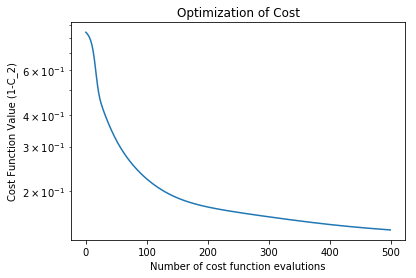

None

In [21]:
x2 =np.linspace(1, len(c2), len(c2))
plt.plot(x2, c2)
plt.title("Optimization of Cost")
plt.xlabel("Number of cost function evalutions")
plt.ylabel("Cost Function Value (1-C_2)")
plt.yscale("log")
display(plt.show())

Input data, before encode:


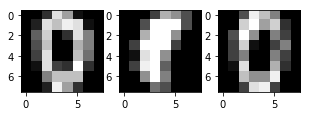

Output data, after decode:


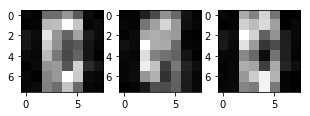

In [23]:
X_test_decode = []
for j in range(len(X_test)):
    X_test_decode.append(list(main_test(n_comp=4,params=res2,input_data=X_test[j],model="B")))

plt.figure(figsize=(5,4))
print("Input data, before encode:")
for index, (image, label) in enumerate(zip(X_test, y_test)):
    plt.subplot(1, 3, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
plt.show()

plt.figure(figsize=(5,4))
print("Output data, after decode:")
for index, (image, label) in enumerate(zip(X_test_decode, y_test)):
    plt.subplot(1, 3, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
plt.show()

### Scaling of parameters

In [ ]:
print("Number of parameters needed for methods A and B:")
for i in range(2,10):
    print(f"n = {i}, A: {int(15*i*(i-1)/2)}, \tB: {3*i*(i-1)+6*i}")